In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
train=pd.read_csv("/content/drive/MyDrive/univ.ai/univ_data/Training Data.csv")

In [3]:
train.head()

,Id,income,age,experience,married,house_ownership,car_ownership,profession,city,state,current_job_years,current_house_years,risk_flag
0,1,1303835,23,3,single,rented,no,Mechanical_engineer,Rewa,Madhya_Pradesh,3,13,0
1,2,7574516,40,10,single,rented,no,Software_Developer,Parbhani,Maharashtra,9,13,0
2,3,3991815,66,4,married,rented,no,Technical_writer,Alappuzha,Kerala,4,10,0
3,4,6256451,41,2,single,rented,yes,Software_Developer,Bhubaneswar,Odisha,2,12,1
4,5,5768871,47,11,single,rented,no,Civil_servant,Tiruchirappalli[10],Tamil_Nadu,3,14,1


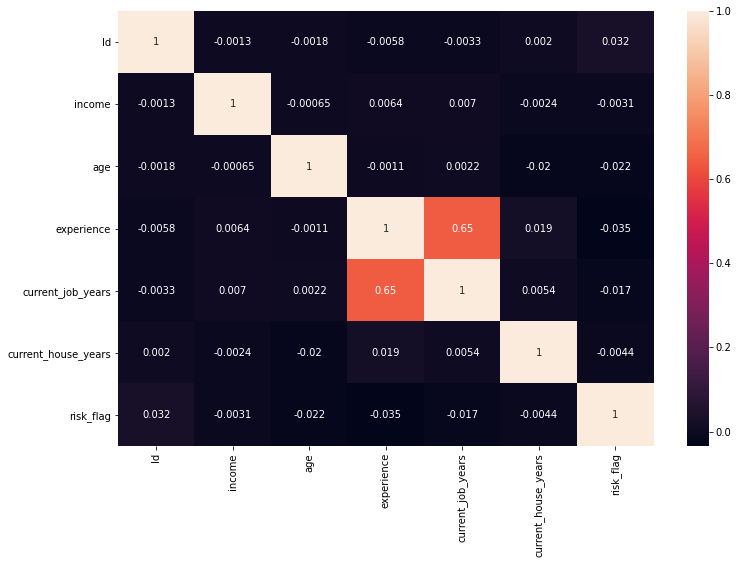

In [4]:
plt.figure(figsize=(12,8))
sns.heatmap(train.corr(),annot=True)

# Feature Enginnering

In [5]:
pip install prince

In [6]:
test=pd.read_csv("/content/drive/MyDrive/univ.ai/univ_data/Test Data.csv")
test.rename(columns={"id":"Id"},inplace=True)

y=train['risk_flag']
train_no_target=train.drop('risk_flag',axis=1)
loans=pd.concat([train_no_target,test],axis=0)

categorical_cols= ['car_ownership', 'profession', 'city','state']
numerical_cols =  ['income', 'age', 'experience', 'current_job_years','current_house_years']

In [7]:
loans

,Id,income,age,experience,married,house_ownership,car_ownership,profession,city,state,current_job_years,current_house_years
0,1,1303835,23,3,single,rented,no,Mechanical_engineer,Rewa,Madhya_Pradesh,3,13
1,2,7574516,40,10,single,rented,no,Software_Developer,Parbhani,Maharashtra,9,13
2,3,3991815,66,4,married,rented,no,Technical_writer,Alappuzha,Kerala,4,10
3,4,6256451,41,2,single,rented,yes,Software_Developer,Bhubaneswar,Odisha,2,12
4,5,5768871,47,11,single,rented,no,Civil_servant,Tiruchirappalli[10],Tamil_Nadu,3,14
...,...,...,...,...,...,...,...,...,...,...,...,...
27995,27996,9955481,57,13,single,rented,no,Statistician,Eluru[25],Andhra Pradesh,5,10
27996,27997,2917765,47,9,single,rented,no,Technical writer,Ratlam,Madhya Pradesh,9,14
27997,27998,8082415,24,5,single,rented,no,Lawyer,Mira-Bhayandar,Maharashtra,4,13
27998,27999,9474180,51,13,single,rented,yes,Chartered Accountant,Bhilai,Chhattisgarh,13,14


In [8]:
print(categorical_cols,numerical_cols)

['car_ownership', 'profession', 'city', 'state'] ['income', 'age', 'experience', 'current_job_years', 'current_house_years']


In [9]:
import prince
mca = prince.MCA(n_components=2,random_state=42)
mca_features=mca.fit_transform(loans[categorical_cols])

In [10]:
mca1=mca_features[0]
print(mca1)

0        0.309445
1        0.099267
2       -0.193964
3       -0.912883
4        0.789893
           ...   
27995    0.046637
27996    0.321129
27997   -0.048994
27998   -1.358971
27999    0.068114
Name: 0, Length: 280000, dtype: float64


In [11]:
train_no_target.loc[:,'MCA1'] = mca1[:len(train_no_target)]
test.loc[:,'MCA1']= mca1[len(train_no_target):]

In [12]:
from sklearn.decomposition import PCA

pca= PCA(n_components=2,random_state=202020).fit(loans[numerical_cols])
train_no_target.loc[:,'PCA1']= pca.transform(train_no_target[numerical_cols])[:,0]
test.loc[:,'PCA1']= pca.transform(test[numerical_cols])[:,0]

train_no_target.loc[:,'PCA2']= pca.transform(train_no_target[numerical_cols])[:,1]
test.loc[:,'PCA2']= pca.transform(test[numerical_cols])[:,1]

In [13]:
loans=pd.concat([train_no_target,test],axis=0)

In [14]:
loans.head()

,Id,income,age,experience,married,house_ownership,car_ownership,profession,city,state,current_job_years,current_house_years,MCA1,PCA1,PCA2
0,1,1303835,23,3,single,rented,no,Mechanical_engineer,Rewa,Madhya_Pradesh,3,13,0.309445,-3.696526e+06,-26.983843
1,2,7574516,40,10,single,rented,no,Software_Developer,Parbhani,Maharashtra,9,13,0.099267,2.574155e+06,-9.952688
2,3,3991815,66,4,married,rented,no,Technical_writer,Alappuzha,Kerala,4,10,-0.193964,-1.008546e+06,16.033857
3,4,6256451,41,2,single,rented,yes,Software_Developer,Bhubaneswar,Odisha,2,12,-0.912883,1.256090e+06,-8.960311
4,5,5768871,47,11,single,rented,no,Civil_servant,Tiruchirappalli[10],Tamil_Nadu,3,14,0.789893,7.685097e+05,-2.966084


In [15]:
def agg_groupby(df,primary_key,operations,agg_cols):
  return df.groupby(primary_key).agg(operations).reset_index().rename(columns=agg_cols)

def left_join(df1,df2,primary_key):
  return df1.merge(df2,how='left',on=primary_key)

def aggregation(df,primary_key,operation,cols):
  for c in cols:
    df=left_join(df,
                 agg_groupby(df,
                             [primary_key],
                             {c:operation},
                             {c:primary_key+"_"+operation+"_"+c}),
                 primary_key)
  return df

In [16]:
aggregation_columns = ['income', 'age', 'experience', 'current_job_years','current_house_years', 'PCA1','PCA2','MCA1']
operation=['mean','median','min','max','std']

In [17]:
for op in operation:
  loans=aggregation(loans,'state',op,aggregation_columns)

for op in operation:
  loans=aggregation(loans,'city',op,aggregation_columns)

for op in operation:
  loans=aggregation(loans,'profession',op,aggregation_columns)

for op in operation:
  loans=aggregation(loans,'married',op,aggregation_columns)

for op in operation:
  loans=aggregation(loans,'house_ownership',op,aggregation_columns)

for op in operation:
  loans=aggregation(loans,'car_ownership',op,aggregation_columns)

In [19]:
loans=aggregation(loans,'profession','nunique',['state'])
loans=aggregation(loans,'profession','nunique',['city'])
loans=aggregation(loans,'married','nunique',['profession'])
loans=aggregation(loans,'house_ownership','nunique',['profession'])

In [22]:
loans.head()

,Id,income,age,experience,married,house_ownership,car_ownership,profession,city,state,current_job_years,current_house_years,MCA1,PCA1,PCA2,state_mean_income,state_mean_age,state_mean_experience,state_mean_current_job_years,state_mean_current_house_years,state_mean_PCA1,state_mean_PCA2,state_mean_MCA1,state_median_income,state_median_age,state_median_experience,state_median_current_job_years,state_median_current_house_years,state_median_PCA1,state_median_PCA2,state_median_MCA1,state_min_income,state_min_age,state_min_experience,state_min_current_job_years,state_min_current_house_years,state_min_PCA1,state_min_PCA2,state_min_MCA1,state_max_income,...,car_ownership_mean_current_house_years,car_ownership_mean_PCA1,car_ownership_mean_PCA2,car_ownership_mean_MCA1,car_ownership_median_income,car_ownership_median_age,car_ownership_median_experience,car_ownership_median_current_job_years,car_ownership_median_current_house_years,car_ownership_median_PCA1,car_ownership_median_PCA2,car_ownership_median_MCA1,car_ownership_min_income,car_ownership_min_age,car_ownership_min_experience,car_ownership_min_current_job_years,car_ownership_min_current_house_years,car_ownership_min_PCA1,car_ownership_min_PCA2,car_ownership_min_MCA1,car_ownership_max_income,car_ownership_max_age,car_ownership_max_experience,car_ownership_max_current_job_years,car_ownership_max_current_house_years,car_ownership_max_PCA1,car_ownership_max_PCA2,car_ownership_max_MCA1,car_ownership_std_income,car_ownership_std_age,car_ownership_std_experience,car_ownership_std_current_job_years,car_ownership_std_current_house_years,car_ownership_std_PCA1,car_ownership_std_PCA2,car_ownership_std_MCA1,profession_nunique_state,profession_nunique_city,married_nunique_profession,house_ownership_nunique_profession
0,1,1303835,23,3,single,rented,no,Mechanical_engineer,Rewa,Madhya_Pradesh,3,13,0.309445,-3.696526e+06,-26.983843,4.888681e+06,49.579096,10.543407,6.576406,12.011188,-111680.589809,-0.385460,0.285050,4735088,49.0,11,6,12,-265273.264218,-0.954734,0.298030,13629,21,0,0,10,-4.986732e+06,-28.991892,0.074841,9994932,...,11.997429,-7120.793015,-0.108177,0.008086,5022180,50,10,6,12,21818.735782,0.031143,-0.075333,10318,21,0,0,10,-4.990043e+06,-28.991892,-2.731118,9999814,79,20,14,14,4.999453e+06,29.062780,5.206361,2.878478e+06,17.134393,5.999634,3.625736,1.396239,2.878478e+06,17.134440,0.717207,29,299,74,74
1,2,7574516,40,10,single,rented,no,Software_Developer,Parbhani,Maharashtra,9,13,0.099267,2.574155e+06,-9.952688,5.017456e+06,50.136905,10.012926,6.405502,11.935968,17095.049744,0.173001,-0.025765,5194149,50.0,10,6,12,193787.735782,0.040715,-0.020857,10318,21,0,0,10,-4.990043e+06,-28.990043,-0.238313,9987388,...,11.997429,-7120.793015,-0.108177,0.008086,5022180,50,10,6,12,21818.735782,0.031143,-0.075333,10318,21,0,0,10,-4.990043e+06,-28.991892,-2.731118,9999814,79,20,14,14,4.999453e+06,29.062780,5.206361,2.878478e+06,17.134393,5.999634,3.625736,1.396239,2.878478e+06,17.134440,0.717207,29,299,74,74
2,3,3991815,66,4,married,rented,no,Technical_writer,Alappuzha,Kerala,4,10,-0.193964,-1.008546e+06,16.033857,5.153478e+06,50.800439,8.561373,5.919110,12.071014,153116.709759,0.836751,-0.189365,5421502,52.0,8,6,12,421140.735782,2.023758,-0.193439,16212,21,0,0,10,-4.984149e+06,-28.991691,-0.404534,9987955,...,11.997429,-7120.793015,-0.108177,0.008086,5022180,50,10,6,12,21818.735782,0.031143,-0.075333,10318,21,0,0,10,-4.990043e+06,-28.991892,-2.731118,9999814,79,20,14,14,4.999453e+06,29.062780,5.206361,2.878478e+06,17.134393,5.999634,3.625736,1.396239,2.878478e+06,17.134440,0.717207,28,297,74,74
3,4,6256451,41,2,single,rented,yes,Software_Developer,Bhubaneswar,Odisha,2,12,-0.912883,1.256090e+06,-8.960311,4.931571e+06,49.287296,11.217366,6.432401,12.014763,-68790.362703,-0.677208,-1.024980,4739803,50.0,12,6,12,-260558.264218,0.052339,-1.011762,13696,21,0,0,10,-4.986665e+06,-28.986481,-1.223697,9991569,...,11.996646,16509.690473,0.250809,-0.018749,4939664,50,10,6,12,-60697.264218,0.030290,-0.092037,10

# Remove columns with unique value 

In [59]:
counts=loans.nunique()
to_del = [i for i,v in enumerate(counts) if v == 1]

In [68]:
col_names_del=loans.nunique().index[to_del]

In [70]:
loans.drop(col_names_del,axis=1,inplace=True)

In [75]:
loans.columns

Index(['Id', 'income', 'age', 'experience', 'married', 'house_ownership',
       'car_ownership', 'profession', 'city', 'state',
       ...
       'profession_max_MCA1', 'profession_std_income', 'profession_std_age',
       'profession_std_experience', 'profession_std_current_job_years',
       'profession_std_current_house_years', 'profession_std_PCA1',
       'profession_std_MCA1', 'profession_nunique_state',
       'profession_nunique_city'],
      dtype='object', length=110)

In [74]:
# from sklearn.feature_selection import VarianceThreshold
# transform = VarianceThreshold(threshold=0.3)
# transform.fit_transform(loans[numerical_cols]).shape

(279987, 5)

# Preprocessing

In [23]:
train = loans[:len(train)]
test  = loans[len(train):]
print(train.shape,test.shape)

(252000, 259) (28000, 259)


In [24]:
from imblearn.over_sampling import RandomOverSampler
oversample = RandomOverSampler(sampling_strategy='minority')
X_over, y_over = oversample.fit_resample(train,y)
X_over=pd.DataFrame(X_over,columns=train.columns)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [25]:
print(X_over.shape,y_over.shape)

(442008, 259) (442008,)


# KNN 

In [26]:
x_train_knn=pd.get_dummies(data=X_over,columns=["house_ownership","married","car_ownership"],drop_first=True)
x_train_knn.drop(["Id","profession","city","state"],axis=1,inplace=True)

In [27]:
x_train_knn

,income,age,experience,current_job_years,current_house_years,MCA1,PCA1,PCA2,state_mean_income,state_mean_age,state_mean_experience,state_mean_current_job_years,state_mean_current_house_years,state_mean_PCA1,state_mean_PCA2,state_mean_MCA1,state_median_income,state_median_age,state_median_experience,state_median_current_job_years,state_median_current_house_years,state_median_PCA1,state_median_PCA2,state_median_MCA1,state_min_income,state_min_age,state_min_experience,state_min_current_job_years,state_min_current_house_years,state_min_PCA1,state_min_PCA2,state_min_MCA1,state_max_income,state_max_age,state_max_experience,state_max_current_job_years,state_max_current_house_years,state_max_PCA1,state_max_PCA2,state_max_MCA1,...,car_ownership_median_income,car_ownership_median_age,car_ownership_median_experience,car_ownership_median_current_job_years,car_ownership_median_current_house_years,car_ownership_median_PCA1,car_ownership_median_PCA2,car_ownership_median_MCA1,car_ownership_min_income,car_ownership_min_age,car_ownership_min_experience,car_ownership_min_current_job_years,car_ownership_min_current_house_years,car_ownership_min_PCA1,car_ownership_min_PCA2,car_ownership_min_MCA1,car_ownership_max_income,car_ownership_max_age,car_ownership_max_experience,car_ownership_max_current_job_years,car_ownership_max_current_house_years,car_ownership_max_PCA1,car_ownership_max_PCA2,car_ownership_max_MCA1,car_ownership_std_income,car_ownership_std_age,car_ownership_std_experience,car_ownership_std_current_job_years,car_ownership_std_current_house_years,car_ownership_std_PCA1,car_ownership_std_PCA2,car_ownership_std_MCA1,profession_nunique_state,profession_nunique_city,married_nunique_profession,house_ownership_nunique_profession,house_ownership_owned,house_ownership_rented,married_single,car_ownership_yes
0,1303835,23,3,3,13,0.309445,-3.69653e+06,-26.9838,4.88868e+06,49.5791,10.5434,6.57641,12.0112,-111681,-0.38546,0.28505,4735088,49,11,6,12,-265273,-0.954734,0.29803,13629,21,0,0,10,-4.98673e+06,-28.9919,0.0748413,9994932,79,20,14,14,4.99457e+06,29.0602,0.49547,...,5022180,50,10,6,12,21818.7,0.0311432,-0.0753326,10318,21,0,0,10,-4.99004e+06,-28.9919,-2.73112,9999814,79,20,14,14,4.99945e+06,29.0628,5.20636,2.87848e+06,17.1344,5.99963,3.62574,1.39624,2.87848e+06,17.1344,0.717207,29,299,74,74,0,1,1,0
1,7574516,40,10,9,13,0.0992672,2.57415e+06,-9.95269,5.01746e+06,50.1369,10.0129,6.4055,11.936,17095,0.173001,-0.0257652,5194149,50,10,6,12,193788,0.0407147,-0.020857,10318,21,0,0,10,-4.99004e+06,-28.99,-0.238313,9987388,79,20,14,14,4.98703e+06,29.0584,0.25871,...,5022180,50,10,6,12,21818.7,0.0311432,-0.0753326,10318,21,0,0,10,-4.99004e+06,-28.9919,-2.73112,9999814,79,20,14,14,4.99945e+06,29.0628,5.20636,2.87848e+06,17.1344,5.99963,3.62574,1.39624,2.87848e+06,17.1344,0.717207,29,299,74,74,0,1,1,0
2,3991815,66,4,4,10,-0.193964,-1.00855e+06,16.0339,5.15348e+06,50.8004,8.56137,5.91911,12.071,153117,0.836751,-0.189365,5421502,52,8,6,12,421141,2.02376,-0.193439,16212,21,0,0,10,-4.98415e+06,-28.9917,-0.404534,9987955,79,20,14,14,4.98759e+06,29.0572,0.0846877,...,5022180,50,10,6,12,21818.7,0.0311432,-0.0753326,10318,21,0,0,10,-4.99004e+06,-28.9919,-2.73112,9999814,79,20,14,14,4.99945e+06,29.0628,5.20636,2.87848e+06,17.1344,5.99963,3.62574,1.39624,2.87848e+06,17.1344,0.717207,28,297,74,74,0,1,0,0
3,6256451,41,2,2,12,-0.912883,1.25609e+06,-8.96031,4.93157e+06,49.2873,11.2174,6.4324,12.0148,-68790.4,-0.677208,-1.02498,4739803,50,12,6,12,-260558,0.0523394,-1.01176,13696,21,0,0,10,-4.98667e+06,-28.9865,-1.2237,9991569,79,20,14,14,4.99121e+06,29.0589,-0.756253,...,4939664,50,10,6,12,-60697.3,0.03029,-0.0920367,10310,21,0,0,10,-4.99005e+06,-28.9917,-2.71092,9999938,79,20,14,14,4.99958e+06,29.0637,5.19331,2.87348e+06,16.9188,6.01709,3.69475,1.40508,2.87348e+06,16.9187,0.698244,29,299,74,74,0,1,1,1
4,5768871,47,11,3,14,0.789893,768510,-2.96608,5.04438e+06,50.1046,10.3934,6.55439,11.9858,44021.1,0.140802,0.739489,5074244,51,10,6,12,73882.7,1.01823,0.741247,11735,21,0

In [28]:
from sklearn.model_selection import train_test_split
x_train,x_val,y_train,y_val=train_test_split(x_train_knn,y_over,random_state=0,test_size=0.2,shuffle=True)

In [31]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score,plot_confusion_matrix
grid_params={
    'n_neighbors':[3,5,11,15,21],
    'weights':['uniform','distance'],
    'metric':['euclidean','manhattan']
}
gs=GridSearchCV(KNeighborsClassifier(),grid_params,verbose=2,cv=3)

gs_results=gs.fit(x_train,y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] metric=euclidean, n_neighbors=3, weights=uniform ................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] . metric=euclidean, n_neighbors=3, weights=uniform, total= 1.6min
[CV] metric=euclidean, n_neighbors=3, weights=uniform ................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.6min remaining:    0.0s


[CV] . metric=euclidean, n_neighbors=3, weights=uniform, total= 1.7min
[CV] metric=euclidean, n_neighbors=3, weights=uniform ................
[CV] . metric=euclidean, n_neighbors=3, weights=uniform, total= 1.7min
[CV] metric=euclidean, n_neighbors=3, weights=distance ...............
[CV]  metric=euclidean, n_neighbors=3, weights=distance, total= 1.8min
[CV] metric=euclidean, n_neighbors=3, weights=distance ...............
[CV]  metric=euclidean, n_neighbors=3, weights=distance, total= 1.6min
[CV] metric=euclidean, n_neighbors=3, weights=distance ...............
[CV]  metric=euclidean, n_neighbors=3, weights=distance, total= 1.3min
[CV] metric=euclidean, n_neighbors=5, weights=uniform ................
[CV] . metric=euclidean, n_neighbors=5, weights=uniform, total= 1.5min
[CV] metric=euclidean, n_neighbors=5, weights=uniform ................
[CV] . metric=euclidean, n_neighbors=5, weights=uniform, total= 1.5min
[CV] metric=euclidean, n_neighbors=5, weights=uniform ................
[CV] .

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 124.1min finished


In [34]:
import pickle
pickle.dump(gs_results, open("knn_extraFeatures_noID.sav", 'wb'))

In [32]:
y_pred_val=gs_results.predict(x_val)
auc_test = roc_auc_score(y_val, y_pred_val)
print('ROC AUC test: %f' % auc_test)

ROC AUC test: 0.929935


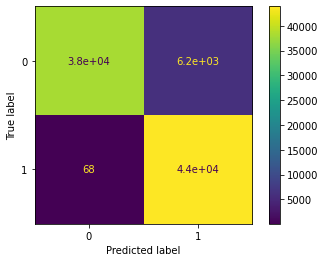

In [33]:
plot_confusion_matrix(gs_results,x_val,y_val)

In [36]:
test_knn=pd.get_dummies(data=test,columns=["house_ownership","married","car_ownership"],drop_first=True)
test_knn.drop(["Id","profession","city","state"],axis=1,inplace=True)

In [38]:
pred_knn=gs_results.predict(test_knn)
result=pd.DataFrame()
result["id"]=test["Id"]
result["risk_flag"]=pred_knn
print(result.risk_flag.value_counts())

0    21111
1     6889
Name: risk_flag, dtype: int64


In [40]:
result.to_csv("knn_extraFeat_noID.csv",index=False)

# Catboost 

In [104]:
X_over.drop("Id",axis=1,inplace=True)

In [105]:
from sklearn.model_selection import train_test_split
x_train,x_val,y_train,y_val=train_test_split(X_over,y_over,random_state=0,test_size=0.2,shuffle=True)

In [ ]:
categorical_cols= ['married', 'house_ownership', 'car_ownership', 'profession', 'city','state']
for cols in categorical_cols:
    x_train[cols] = x_train[cols].astype(str)
    x_val[cols]  = x_val[cols].astype(str)

cate_features_index = np.where(x_train.dtypes == object)[0]
print(cate_features_index)

In [114]:
x_train

,income,age,experience,married,house_ownership,car_ownership,profession,city,state,current_job_years,current_house_years,MCA1,PCA1,state_mean_income,state_mean_age,state_mean_experience,state_mean_current_job_years,state_mean_current_house_years,state_mean_PCA1,state_mean_MCA1,state_median_income,state_median_age,state_median_experience,state_median_current_job_years,state_median_current_house_years,state_median_PCA1,state_median_MCA1,state_min_income,state_min_age,state_min_experience,state_min_current_job_years,state_min_PCA1,state_min_MCA1,state_max_income,state_max_age,state_max_experience,state_max_current_job_years,state_max_PCA1,state_max_MCA1,state_std_income,...,city_max_current_job_years,city_max_PCA1,city_max_MCA1,city_std_income,city_std_age,city_std_experience,city_std_current_job_years,city_std_current_house_years,city_std_PCA1,city_std_MCA1,profession_mean_income,profession_mean_age,profession_mean_experience,profession_mean_current_job_years,profession_mean_current_house_years,profession_mean_PCA1,profession_mean_MCA1,profession_median_income,profession_median_age,profession_median_experience,profession_median_current_job_years,profession_median_current_house_years,profession_median_PCA1,profession_median_MCA1,profession_min_income,profession_min_PCA1,profession_min_MCA1,profession_max_income,profession_max_age,profession_max_PCA1,profession_max_MCA1,profession_std_income,profession_std_age,profession_std_experience,profession_std_current_job_years,profession_std_current_house_years,profession_std_PCA1,profession_std_MCA1,profession_nunique_state,profession_nunique_city
75285,5982800,39,12,single,rented,no,Analyst,Chandrapur,Maharashtra,12,10,-0.42708,982439,5.01746e+06,50.1369,10.0129,6.4055,11.936,17095,-0.391318,5194149,50,10,6,12,193788,-0.396774,10318,21,0,0,-4.99004e+06,-0.536496,9987388,79,20,14,4.98703e+06,-0.185659,2.90827e+06,...,14,4.95767e+06,-0.26286,3.19819e+06,14.2536,5.49608,3.61217,1.35187,3.19819e+06,0.0544055,4.88944e+06,47.8969,10.151,6.50568,11.9965,-110922,-0.0363316,5.07414e+06,46,11,6,12,73778.7,-0.122791,11550,-4.98881e+06,-1.8112,9993798,79,4.99344e+06,2.3545,2.79272e+06,17.9491,6.05147,3.84957,1.38321,2.79272e+06,0.556867,35,302
191906,2093984,77,9,single,rented,no,Hotel_Manager,Dehri[30],Bihar,3,14,0.60686,-2.90638e+06,5.05159e+06,49.8048,10.2387,6.49579,11.9942,51228.3,0.664556,4939664,50,10,6,12,-60697.3,0.669308,12766,21,0,0,-4.9876e+06,0.492437,9993041,79,20,14,4.99268e+06,0.818742,2.89163e+06,...,14,4.99268e+06,0.776269,3.23186e+06,16.87,5.85972,4.14873,1.37555,3.23186e+06,0.0532147,4.99688e+06,51.0595,10.1586,6.67188,12.0431,-3482.93,-0.0732995,5.19034e+06,51,11,6,12,189977,-0.129806,17801,-4.98256e+06,-1.8133,9992692,79,4.99233e+06,2.33485,2.80413e+06,17.8112,6.0309,3.87952,1.43425,2.80413e+06,0.545388,26,295
366637,2711896,62,11,single,rented,no,Civil_engineer,Anand,Gujarat,7,14,-0.0128748,-2.28847e+06,4.99631e+06,50.1321,10.2767,6.41986,11.9977,-4055.58,0.0322074,5265885,50,10,6,12,265524,0.0320055,13792,21,0,0,-4.98657e+06,-0.124289,9999180,79,20,14,4.99882e+06,0.190077,2.82884e+06,...,14,4.94038e+06,0.143172,2.73229e+06,16.004,4.80323,3.24841,1.39204,2.73229e+06,0.0618165,4.75544e+06,48.5243,9.94801,6.65901,11.8876,-244920,-0.0925678,4.61355e+06,47,10,6,12,-386808,-0.178162,25674,-4.97469e+06,-1.82909,9992141,79,4.99178e+06,2.32467,2.81166e+06,17.0474,5.55273,3.77668,1.46469,2.81166e+06,0.583886,29,299
50592,9803522,55,14,single,rented,no,Police_officer,Guna,Madhya_Pradesh,14,11,0.187117,4.80316e+06,4.88868e+06,49.5791,10.5434,6.57641,12.0112,-111681,0.152428,4735088,49,11,6,12,-265273,0.15144,13629,21,0,0,-4.98673e+06,-0.00880432,9994932,79,20,14,4.99457e+06,0.314542,2.89145e+06,...,14,4.97614e+06,0.278745,3.28358e+06,17.964,5.53683,4.32838,1.44217,3.28358e+06,0.0580988,4.50292e+06,48.5567,9.81867,6.02959,11.8993,-497446,0.0881801,4.14775e+06,49,9,6,12,-852607,0.0644721,13220,-4.98714e+06,-1.74114,9999938,79,4.99958e+06,2.44475,2.8847e+06,16.4968,5.55175,3.32991,1.37922,2

In [107]:
cate_features_index

array([4, 5, 6, 7, 8, 9])

In [100]:
pip install catboost

     |████████████████████████████████| 67.3MB 96kB/s 


In [101]:
from catboost import CatBoostClassifier
cat=CatBoostClassifier(n_estimators=2000,random_state=0)
cat.fit(x_train,y_train,cat_features=cate_features_index,eval_set=(x_val,y_val))

Learning rate set to 0.099872
0:	learn: 0.6851543	test: 0.6851790	best: 0.6851790 (0)	total: 783ms	remaining: 26m 5s
1:	learn: 0.6777035	test: 0.6777603	best: 0.6777603 (1)	total: 1.48s	remaining: 24m 43s
2:	learn: 0.6736198	test: 0.6736636	best: 0.6736636 (2)	total: 2.21s	remaining: 24m 29s
3:	learn: 0.6695365	test: 0.6695425	best: 0.6695425 (3)	total: 2.84s	remaining: 23m 36s
4:	learn: 0.6451819	test: 0.6439950	best: 0.6439950 (4)	total: 3.52s	remaining: 23m 24s
5:	learn: 0.6228393	test: 0.6197240	best: 0.6197240 (5)	total: 3.93s	remaining: 21m 46s
6:	learn: 0.6064726	test: 0.6021268	best: 0.6021268 (6)	total: 4.36s	remaining: 20m 39s
7:	learn: 0.5936266	test: 0.5879145	best: 0.5879145 (7)	total: 4.85s	remaining: 20m 7s
8:	learn: 0.5815820	test: 0.5745620	best: 0.5745620 (8)	total: 5.34s	remaining: 19m 40s
9:	learn: 0.5789239	test: 0.5721087	best: 0.5721087 (9)	total: 5.97s	remaining: 19m 49s
10:	learn: 0.5764853	test: 0.5698253	best: 0.5698253 (10)	total: 6.59s	remaining: 19m 52s
11

In [102]:
y_pred_val=cat.predict(x_val)
auc_test = roc_auc_score(y_val, y_pred_val)
print('ROC AUC test: %f' % auc_test)

ROC AUC test: 0.944111


In [143]:
import pickle
pickle.dump(cat, open("catboost_featSelection.sav", 'wb'))